In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
# provide custom loss function
data_dir = '../230517_Consolidated Data'

# Compute class weights and custom loss function
total_count = len(os.listdir(data_dir))
ok_count = len(os.listdir(os.path.join(data_dir, 'ok')))
defect_count = len(os.listdir(os.path.join(data_dir, 'defect')))

weights = tf.constant([total_count/ok_count, total_count/defect_count])

# Define custom loss function
def weighted_cross_entropy(y_true, y_pred):
 
    ce = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    y_true_class = tf.argmax(y_true, axis=1)
    weights_ce = tf.gather(weights, y_true_class)
    weighted_ce = ce * weights_ce
    
    return tf.reduce_mean(weighted_ce)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [3]:
# provide custom layer
class SobelFilteringLayer(tf.keras.layers.Layer):
    def __init__(self, name='SobelFilteringLayer', **kwargs):
        super(SobelFilteringLayer, self).__init__()
    
    def call(self, inputs):

        gray_images = tf.image.rgb_to_grayscale(inputs)
        sobel_edges = tf.image.sobel_edges(gray_images)
        edge_x = sobel_edges[..., 0]
        edge_y = sobel_edges[..., 1]
       
        edges = tf.stack([edge_x, edge_y], axis=-1)
     
        return tf.reshape(edges, [-1, inputs.shape[1], inputs.shape[2], 2])

In [7]:
# load model
model_path = '../models/sobel/particledrag_dataset=230517_epochs=15_WeightedCategoricalCrossentropy_LRS=True_Sobel.h5'

model = load_model(model_path, custom_objects={'weighted_cross_entropy': weighted_cross_entropy, 'SobelFilteringLayer': SobelFilteringLayer})

In [8]:
# load test set
test_dir = os.path.join('..', 'eval-data')

test_data = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(480, 640), label_mode='categorical')

Found 6000 files belonging to 2 classes.


In [9]:
# Get the model's convolutional layers
conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Get the last convolutional layer
last_conv_layer = conv_layers[-1]

In [10]:
# Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model(
    [model.inputs], [last_conv_layer.output, model.output]
)

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_model, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

2023-05-18 20:43:26.147155: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 362ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

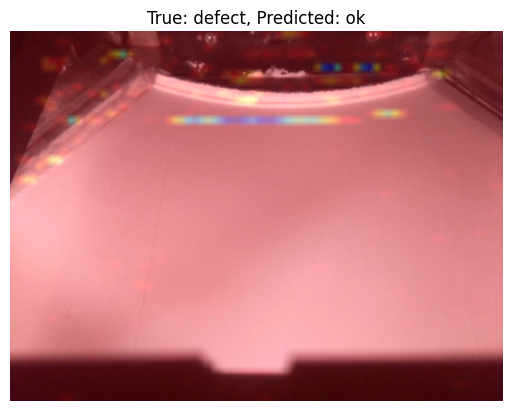

In [12]:
class_names = test_data.class_names  
gradcam_dir = os.path.join('..', '230518_GradCAM')
filename = 0

# Loop over all images
for images, labels in test_data:

    for i in range(images.shape[0]):
        
        img = images[i]
        label = labels[i]

        preds = model.predict(tf.expand_dims(img, axis=0))
        pred_label = class_names[np.argmax(preds[0])]

        heatmap = make_gradcam_heatmap(tf.expand_dims(img, axis=0), model, grad_model)
        
        heatmap = np.uint8(255 * heatmap)
        jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        jet_big = cv2.resize(jet, (img.shape[1], img.shape[0]))
        superimposed_img = jet_big * 0.4 + img.numpy()

        plt.imshow(superimposed_img / 255.0)
        plt.title(f"True: {class_names[np.argmax(label)]}, Predicted: {pred_label}")
        plt.axis("off")

        # Save the figure to a file
        filename += 1
        plt.savefig(os.path.join(gradcam_dir, f"Sobel_{filename}_gradCAM.png"))
